# Gaussian Mixture Models (GMMs)

Gaussian Mixture Models (GMMs) are probabilistic models that assume data is generated from a mixture of multiple Gaussian distributions. They are widely used for clustering, density estimation, and anomaly detection.

## Mathematical Background

A GMM represents the probability distribution of data as a weighted sum of multiple Gaussian distributions:

\[
P(x) = \sum_{i=1}^{K} \pi_i \mathcal{N}(x | \mu_i, \Sigma_i)
\]

Where:
- \( K \) is the number of Gaussian components.
- \( \pi_i \) is the weight of the \( i \)-th Gaussian component (sum of all weights equals 1).
- \( \mathcal{N}(x | \mu_i, \Sigma_i) \) is the Gaussian distribution with mean \( \mu_i \) and covariance \( \Sigma_i \).

### Expectation-Maximization (EM) Algorithm
GMM parameters are estimated using the **Expectation-Maximization (EM)** algorithm:
1. **Expectation Step (E-Step):** Compute the probability that each data point belongs to each Gaussian component.
2. **Maximization Step (M-Step):** Update the parameters (\( \pi_i, \mu_i, \Sigma_i \)) to maximize the likelihood.

---

## Advantages
- Can model complex distributions.
- Handles overlapping clusters better than k-means.
- Provides soft clustering (probabilistic assignment of points).

## Disadvantages
- Requires specifying the number of Gaussian components.
- Computationally expensive for large datasets.
- Sensitive to initialization.

---

## Applications
- **Image Segmentation:** Identifying different regions in an image.
- **Speech Recognition:** Modeling phonemes in audio data.
- **Financial Fraud Detection:** Identifying anomalies in transaction data.
- **Biological Data Analysis:** Clustering gene expression data.

---

## Examples

### Example 1: Clustering Customer Behavior
A retail company uses GMMs to cluster customers based on purchasing patterns. Unlike k-means, GMM assigns probabilities to each customer belonging to multiple clusters.

### Example 2: Identifying Anomalies in Network Traffic
GMMs help detect unusual network activity by modeling normal traffic patterns and flagging deviations.




In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### Motivating GMM: Weaknesses of k-Means

Let's take a look at some of the weaknesses of k-means and think about how we might improve the cluster model. As we saw in the previous section, given simple, well-separated data, k-means finds suitable clustering results.

For example, if we have simple blobs of data, the k-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

In [4]:
# Generate some data
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

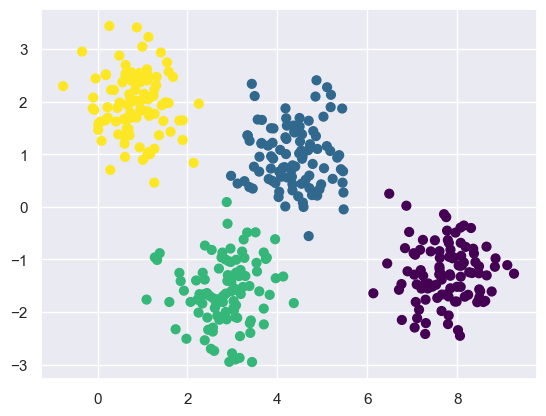

In [5]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them. Unfortunately, the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty). For this, we must think about generalizing the model.

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. We can visualize this cluster model with the following function:

In [6]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

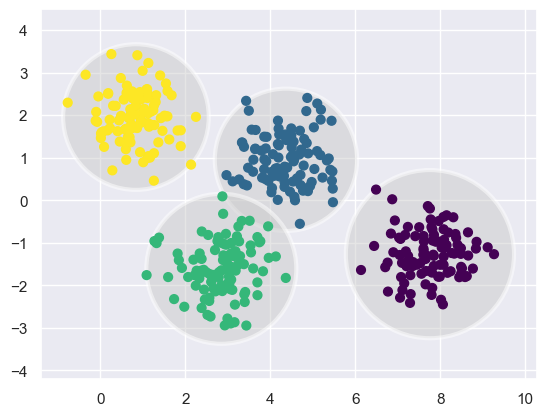

In [7]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation for k-means is that these cluster models must be circular: k-means has no built-in way of accounting for oblong or elliptical clusters. So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

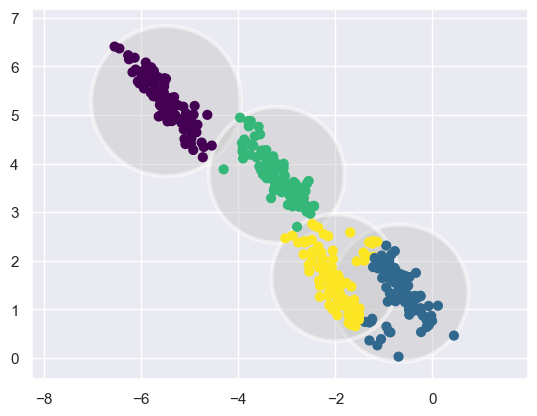

In [8]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

These transformed clusters are non-circular, and thus circular clusters would be a poor fit. Nevertheless, k-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters. This results in a mixing of cluster assignments where the resulting circles overlap; see especially the bottom-right of this plot. One might imagine addressing this particular situation by preprocessing the data with PCA, but in practice there is no guarantee that such a global operation will circularize the individual data.

The two disadvantages of k-means, i.e. its lack of flexibility in cluster shape and lack of probabilistic cluster assignment mean that for many datasets (especially low-dimensional datasets) it may not perform as well.

One might imagine addressing these weaknesses by generalizing the k-means model; for example, by measuring uncertainty in cluster assignment by comparing the distances of each point to all cluster centers, rather than focusing on just the closest. And also imagining allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters. It turns out these are two essential components of a different type of clustering model, Gaussian mixture models.

### Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

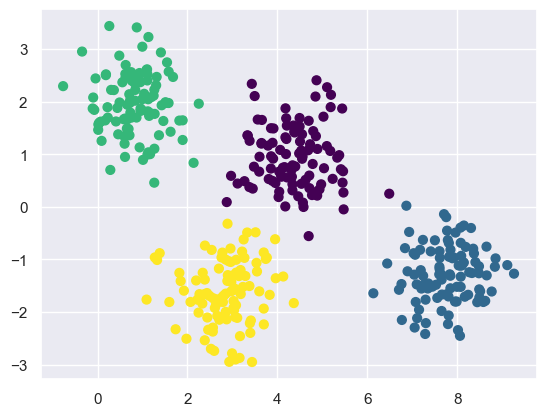

In [10]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

But because GMM contains a probabilistic model under the hood;it is also possible to find probabilistic cluster assignments. In Scikit-Learn this is done using the predict_proba method. This returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster:

In [11]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.537 0.463 0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction:

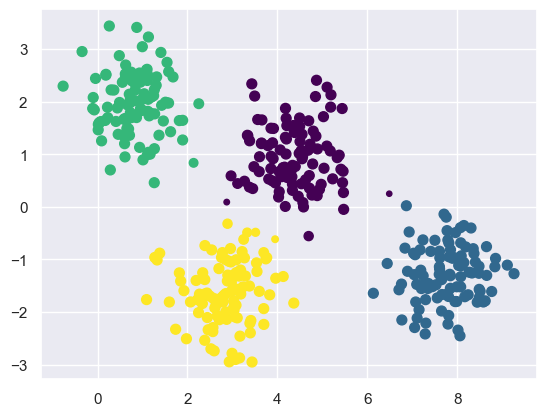

In [12]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Under the hood, a Gaussian mixture model is very similar to k-means: it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:

    1. E-step: for each point, find weights encoding the probability of membership in each cluster
    M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights
    2. The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model. Just as in the k-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

With this in place, we can take a look at what the four-component GMM gives us for our initial data:

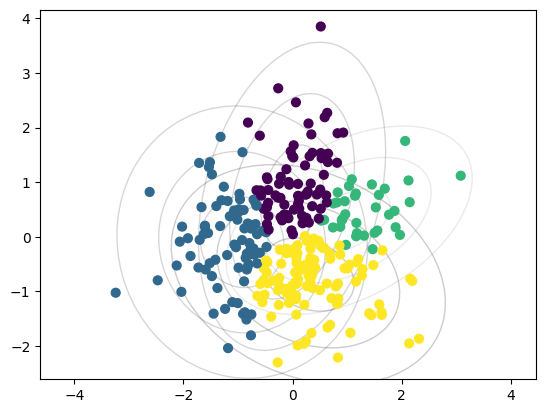

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance."""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the ellipse for different confidence levels
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle=angle, edgecolor='black', facecolor='none', **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    """Plot Gaussian Mixture Model with ellipses."""
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)

    # Scatter plot of the data points
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    # Draw ellipses around Gaussian components
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, ax, alpha=w * w_factor)

# Example Usage:
# Generate sample data
np.random.seed(42)
X = np.random.randn(300, 2)

# Fit GMM and plot
gmm = GaussianMixture(n_components=4, random_state=42)
fig, ax = plt.subplots()
plot_gmm(gmm, X, ax=ax)
plt.show()

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

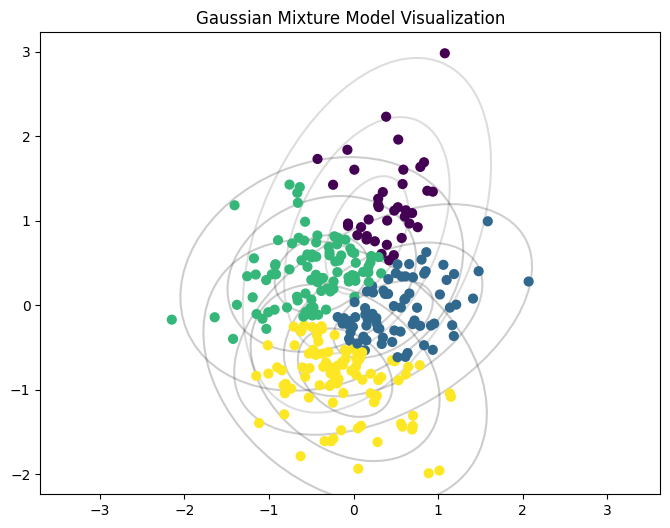

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse representing a Gaussian component."""
    ax = ax or plt.gca()

    # Compute eigenvalues and eigenvectors for covariance
    eigvals, eigvecs = np.linalg.eigh(covariance)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigvals)  # Standard deviation scaling

    # Draw multiple confidence ellipses
    for nsig in range(1, 4):  # 1-sigma, 2-sigma, 3-sigma confidence levels
        ellipse = Ellipse(position, nsig * width, nsig * height, angle=angle, 
                          edgecolor='black', facecolor='none', linewidth=1.5, **kwargs)
        ax.add_patch(ellipse)

def plot_gmm(gmm, X, ax=None):
    """Plot data points and GMM ellipses."""
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)

    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    ax.axis('equal')

    # Define scaling factor for transparency
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, ax=ax, alpha=w * w_factor)

# Generate sample data
np.random.seed(42)
X_stretched = np.random.randn(300, 2) @ np.array([[0.6, -0.2], [0.2, 0.8]])  # Stretching the data

# Fit GMM and plot results
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
fig, ax = plt.subplots(figsize=(8, 6))
plot_gmm(gmm, X_stretched, ax=ax)
plt.title("Gaussian Mixture Model Visualization")
plt.show()

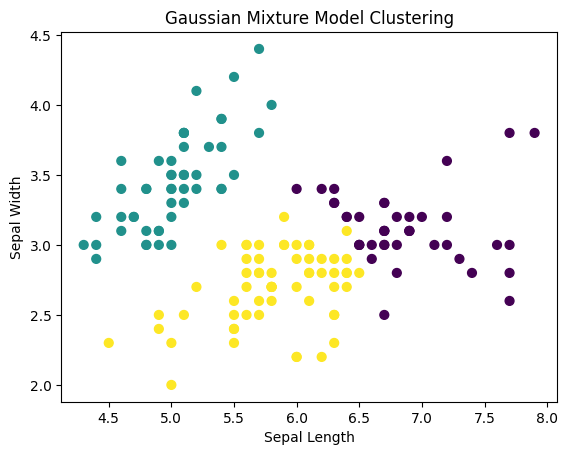

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.mixture import GaussianMixture

# import dataset
iris = datasets.load_iris()
X=iris.data[:,:2]  # we only take the first two features.
# Create a Guassian Mixture Model with 3 components
gmm = GaussianMixture(n_components=3)
# Fit the model to the data
gmm.fit(X)
# Predict the cluster labels
labels = gmm.predict(X)
# Visualize the clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.show()


Log Likelihood:  -1.4978006547501475
BIC:  534.5209964246806
AIC:  483.3401964250442


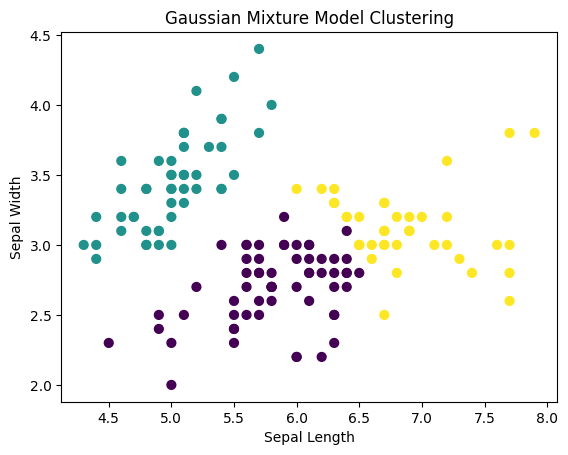

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.mixture import GaussianMixture

# import dataset
iris = datasets.load_iris()
X=iris.data[:,:2]  # we only take the first two features.
# Create a Guassian Mixture Model with 3 components
gmm = GaussianMixture(n_components=3)
# Fit the model to the data
gmm.fit(X)
# Predict the cluster labels
labels = gmm.predict(X)
#Compute the locked likelihood of the model
log_likelihood = gmm.score(X)
# Compute the BIC and AIC
bic = gmm.bic(X)
aic = gmm.aic(X)
# Print the log likelihood, AIC, and BIC
print("Log Likelihood: ", log_likelihood)
print("BIC: ", bic)
print("AIC: ", aic)

# Visualize the clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.show()

### Model Interpretation

- **Log Likelihood:** -1.4978  
  - Indicates how well the model explains the data; values closer to zero suggest a better fit.

- **Akaike Information Criterion (AIC):** 483.34  
  - A measure of model quality with a penalty for complexity. Lower values indicate a better balance of goodness-of-fit and simplicity.

- **Bayesian Information Criterion (BIC):** 534.52  
  - Similar to AIC but applies a stronger penalty for complexity, favoring simpler models.

#### Model Evaluation:
- If comparing multiple models, the one with the lowest AIC/BIC is typically preferred.
- The log likelihood suggests the model does fit the data but could potentially be improved.